### for kaggle notebook

In [1]:
!pip install tabpfn --no-index --find-links=file:///kaggle/input/pip-packages-icr/pip-packages
!mkdir -p /opt/conda/lib/python3.10/site-packages/tabpfn/models_diff
!cp /kaggle/input/pip-packages-icr/pip-packages/prior_diff_real_checkpoint_n_0_epoch_100.cpkt /opt/conda/lib/python3.10/site-packages/tabpfn/models_diff/

Looking in links: file:///kaggle/input/pip-packages-icr/pip-packages
Processing /kaggle/input/pip-packages-icr/pip-packages/tabpfn-0.1.9-py3-none-any.whl


In [2]:
# !pip install lightgbm
# !pip install catboost
# !pip install xgboost
# !pip install tabpfn
# !pip install seaborn
# !pip install optuna

In [3]:
import pandas as pd
import numpy as np
from sklearn.metrics import make_scorer
from sklearn import metrics
from sklearn.preprocessing import RobustScaler
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.model_selection import StratifiedKFold

import optuna

import matplotlib.pyplot as plt
import seaborn as sns
from datetime import date, datetime
import warnings
warnings.filterwarnings("ignore")

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [4]:
#from tabpfn import TabPFNClassifier
from tabpfn.scripts.transformer_prediction_interface import TabPFNClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import random, os
import math


# Flags

In [6]:
# SMOTEをTrueにすると、5FOLDの結果にリークが発生しているように見えるのでCVがあてにならなくなりそう
use_SMOTE = False
check_CV = True
del_BC_CL = False
do_opt = False
use_new_pred = True

use_GPU = False

# 学習ループを行う・行わない（Pytorch部分）
torch_train = False

seed = 57

In [7]:
torch.cuda.is_available()

True

In [8]:
device = "cuda" if torch.cuda.is_available() else "cpu"
if device == "cuda":
    use_GPU = True
use_GPU, device

(True, 'cuda')

# Functions

In [9]:
def calc_new_pred(pred):
    class_0_est_instances = pred[:,0].sum()
    others_est_instances = pred[:,1:].sum()
    
    if class_0_est_instances == 0 or others_est_instances == 0 :
        return pred
    # we reweight the probs, since the loss is also balanced like this
    # our models out of the box optimize CE
    # with these changes they optimize balanced CE
    new_p = pred * np.array([[1/(class_0_est_instances if i==0 else others_est_instances) for i in range(pred.shape[1])]])
    return new_p / np.sum(new_p,axis=1,keepdims=1)

# Read DATAS

In [10]:
df = pd.read_csv("../input/icr-identify-age-related-conditions/train.csv", index_col=[0])
greeks_df = pd.read_csv("../input/icr-identify-age-related-conditions/greeks.csv", index_col=[0])

# マジック（Epsilonを入れる）　🌟
times = greeks_df.Epsilon.copy()
times[greeks_df.Epsilon != 'Unknown'] = greeks_df.Epsilon[greeks_df.Epsilon != 'Unknown'].map(lambda x: datetime.strptime(x,'%m/%d/%Y').toordinal())
times[greeks_df.Epsilon == 'Unknown'] = greeks_df.Epsilon[greeks_df.Epsilon != 'Unknown'].map(lambda x: datetime.strptime(x,'%m/%d/%Y').toordinal()).median()
greeks_df['times'] = times
df = df.merge(greeks_df['times'], left_index = True, right_index = True, how='left')
new_order = df.columns.to_list()
new_order[-2], new_order[-1] = new_order[-1], new_order[-2]
df_train = df.reindex(columns=new_order)
del df

In [11]:
df_test = pd.read_csv("../input/icr-identify-age-related-conditions/test.csv", index_col=[0])
df_test['times'] = times.max()+1
df_test

,AB,AF,AH,AM,AR,AX,AY,AZ,BC,BD,...,FL,FR,FS,GB,GE,GF,GH,GI,GL,times
Id,,,,,,,,,,,,,,,,,,,,,
00eed32682bb,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,737698.0
010ebe33f668,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,737698.0
02fa521e1838,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,737698.0
040e15f562a2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,737698.0
046e85c7cc7f,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,737698.0


In [12]:
df_train['EJ'] = df_train['EJ'].map({'A': 0.0, 'B': 1.0}, na_action=None)
df_test['EJ'] = df_test['EJ'].map({'A': 0.0, 'B': 1.0}, na_action=None)

## nanをmedianに変更

In [13]:
col_mean = df_train.median(axis=0)
for i, colname in enumerate(df_train.columns):
    df_train[colname].fillna(col_mean[i], inplace=True)
df_train

,AB,AF,AH,AM,AR,AX,AY,AZ,BC,BD,...,FR,FS,GB,GE,GF,GH,GI,GL,times,Class
Id,,,,,,,,,,,,,,,,,,,,,
000ff2bfdfe9,0.209377,3109.03329,85.200147,22.394407,8.138688,0.699861,0.025578,9.812214,5.555634,4126.58731,...,1.73855,0.094822,11.339138,72.611063,2003.810319,22.136229,69.834944,0.120343,737137.0,1
007255e47698,0.145282,978.76416,85.200147,36.968889,8.138688,3.632190,0.025578,13.517790,1.229900,5496.92824,...,0.49706,0.568932,9.292698,72.611063,27981.562750,29.135430,32.131996,21.978000,737269.0,0
013f2bd269f5,0.470030,2635.10654,85.200147,32.360553,8.138688,6.732840,0.025578,12.824570,1.229900,5135.78024,...,0.97556,1.198821,37.077772,88.609437,13676.957810,28.022851,35.192676,0.196941,737269.0,0
043ac50845d5,0.252107,3819.65177,120.201618,77.112203,8.138688,3.685344,0.025578,11.053708,1.229900,4169.67738,...,0.49706,0.284466,18.529584,82.416803,2094.262452,39.948656,90.493248,0.155829,737269.0,0
044fb8a146ec,0.380297,3733.04844,85.200147,14.103738,8.138688,3.942255,0.054810,3.396778,102.151980,5728.73412,...,48.50134,0.121914,16.408728,146.109943,8524.370502,45.381316,36.262628,0.096614,737509.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
fd3dafe738fd,0.149555,3130.05946,123.763599,9.513984,13.020852,3.499305,0.077343,8.545512,2.804172,4157.68439,...,1.26092,0.067730,8.967128,217.148554,8095.932828,24.640462,69.191944,21.978000,737681.0,0
fd895603f071,0.435846,5462.03438,85.200147,46.551007,15.973224,5.979825,0.025882,12.622906,3.777550,5654.07556,...,1.24236,0.426699,35.896418,496.994214,3085.308063,29.648928,124.808872,0.145340,737676.0,0
fd8ef6377f76,0.427300,2459.10720,130.138587,55.355778,10.005552,8.070549,0.025578,15.408390,1.229900,5888.87769,...,0.49706,0.067730,19.962092,128.896894,6474.652866,26.166072,119.559420,21.978000,737264.0,0


In [14]:
for i, colname in enumerate(df_test.columns):
    df_test[colname].fillna(col_mean[i], inplace=True)
df_test

,AB,AF,AH,AM,AR,AX,AY,AZ,BC,BD,...,FL,FR,FS,GB,GE,GF,GH,GI,GL,times
Id,,,,,,,,,,,,,,,,,,,,,
00eed32682bb,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,737698.0
010ebe33f668,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,737698.0
02fa521e1838,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,737698.0
040e15f562a2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,737698.0
046e85c7cc7f,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,737698.0


### 列 BC と CL を削除
自分のコードではCVが低下したので一旦コメントアウト

https://www.kaggle.com/competitions/icr-identify-age-related-conditions/discussion/414638

In [15]:
if del_BC_CL:
    df_train = df_train.drop(['BC','CL'], axis=1)
    df_test = df_test.drop(['BC','CL'], axis=1)

### smote

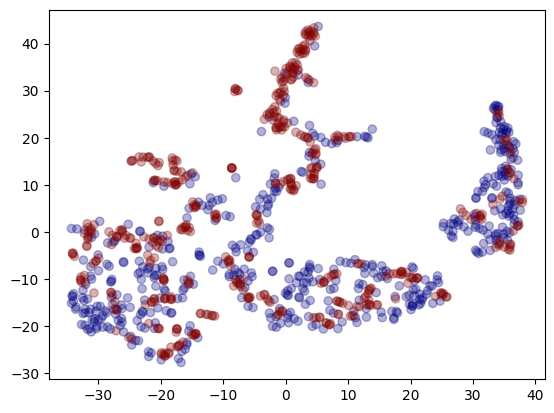

In [16]:
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek

X = df_train[df_train.columns[:-1]]
y = df_train.Class
sm = SMOTETomek(random_state=57)
X_res, y_res = sm.fit_resample(X, y)

from sklearn.manifold import TSNE
pca = TSNE(n_components=2, random_state=0)
X_reduced_tsne = pca.fit_transform(X_res)  # wineデータをPCAで次元圧縮
plt.scatter(X_reduced_tsne[:, 0], X_reduced_tsne[:, 1],
            c=y_res, cmap='jet', alpha=0.3)
plt.show()

if use_SMOTE:
    X_res['Class'] = y_res
    df_train = X_res

In [17]:
df_train

,AB,AF,AH,AM,AR,AX,AY,AZ,BC,BD,...,FR,FS,GB,GE,GF,GH,GI,GL,times,Class
Id,,,,,,,,,,,,,,,,,,,,,
000ff2bfdfe9,0.209377,3109.03329,85.200147,22.394407,8.138688,0.699861,0.025578,9.812214,5.555634,4126.58731,...,1.73855,0.094822,11.339138,72.611063,2003.810319,22.136229,69.834944,0.120343,737137.0,1
007255e47698,0.145282,978.76416,85.200147,36.968889,8.138688,3.632190,0.025578,13.517790,1.229900,5496.92824,...,0.49706,0.568932,9.292698,72.611063,27981.562750,29.135430,32.131996,21.978000,737269.0,0
013f2bd269f5,0.470030,2635.10654,85.200147,32.360553,8.138688,6.732840,0.025578,12.824570,1.229900,5135.78024,...,0.97556,1.198821,37.077772,88.609437,13676.957810,28.022851,35.192676,0.196941,737269.0,0
043ac50845d5,0.252107,3819.65177,120.201618,77.112203,8.138688,3.685344,0.025578,11.053708,1.229900,4169.67738,...,0.49706,0.284466,18.529584,82.416803,2094.262452,39.948656,90.493248,0.155829,737269.0,0
044fb8a146ec,0.380297,3733.04844,85.200147,14.103738,8.138688,3.942255,0.054810,3.396778,102.151980,5728.73412,...,48.50134,0.121914,16.408728,146.109943,8524.370502,45.381316,36.262628,0.096614,737509.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
fd3dafe738fd,0.149555,3130.05946,123.763599,9.513984,13.020852,3.499305,0.077343,8.545512,2.804172,4157.68439,...,1.26092,0.067730,8.967128,217.148554,8095.932828,24.640462,69.191944,21.978000,737681.0,0
fd895603f071,0.435846,5462.03438,85.200147,46.551007,15.973224,5.979825,0.025882,12.622906,3.777550,5654.07556,...,1.24236,0.426699,35.896418,496.994214,3085.308063,29.648928,124.808872,0.145340,737676.0,0
fd8ef6377f76,0.427300,2459.10720,130.138587,55.355778,10.005552,8.070549,0.025578,15.408390,1.229900,5888.87769,...,0.49706,0.067730,19.962092,128.896894,6474.652866,26.166072,119.559420,21.978000,737264.0,0


## スケールを変更

In [18]:
df_train_noscale = df_train.copy()

scaler = RobustScaler().set_output(transform="pandas")
df_train.loc[:, df_train.columns[:-2]] = scaler.fit_transform(df_train[df_train.columns[:-2]])
df_train

,AB,AF,AH,AM,AR,AX,AY,AZ,BC,BD,...,FR,FS,GB,GE,GF,GH,GI,GL,times,Class
Id,,,,,,,,,,,,,,,,,,,,,
000ff2bfdfe9,-0.472222,-0.005214,0.000000,0.069272,0.000000,-1.880769,0.000000,-0.134115,1.123175,-0.463451,...,0.598571,-0.333333,-0.642283,0.000000,-0.359338,-0.716263,0.641741,-0.009952,737137.0,1
007255e47698,-0.680556,-0.989494,0.000000,0.611687,0.000000,-0.607692,0.000000,0.631510,0.000000,0.265382,...,-0.624571,0.681159,-0.819132,0.000000,1.240601,-0.124567,-0.197595,0.990234,737269.0,0
013f2bd269f5,0.375000,-0.224190,0.000000,0.440180,0.000000,0.738462,0.000000,0.488281,0.000000,0.073301,...,-0.153143,2.028986,1.581994,0.290982,0.359598,-0.218622,-0.129459,-0.006447,737269.0,0
043ac50845d5,-0.333333,0.323123,1.226427,2.105694,0.000000,-0.584615,0.000000,0.122396,0.000000,-0.440533,...,-0.624571,0.072464,-0.020900,0.178349,-0.353767,0.789556,1.101632,-0.008328,737269.0,0
044fb8a146ec,0.083333,0.283109,0.000000,-0.239281,0.000000,-0.473077,2.594595,-1.459635,26.204380,0.388671,...,46.670286,-0.275362,-0.204180,1.336815,0.042256,1.248820,-0.105640,-0.011038,737509.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
fd3dafe738fd,-0.666667,0.004501,1.351236,-0.410097,4.882164,-0.665385,4.594595,-0.395833,0.408759,-0.446912,...,0.128000,-0.391304,-0.847267,2.628881,0.015869,-0.504561,0.627426,0.990234,737681.0,0
fd895603f071,0.263889,1.081978,0.000000,0.968303,7.834536,0.411538,0.027027,0.446615,0.661496,0.348963,...,0.109714,0.376812,1.479904,7.718779,-0.292729,-0.081158,1.865560,-0.008808,737676.0,0
fd8ef6377f76,0.236111,-0.305510,1.574611,1.295989,1.866864,1.319231,0.000000,1.022135,0.000000,0.473846,...,-0.624571,-0.391304,0.102894,1.023740,-0.083984,-0.375590,1.748697,0.990234,737264.0,0


In [19]:
df_test_noscale = df_test.copy()

df_test.loc[:,df_test.columns[:-1]] = scaler.transform(df_test[df_test.columns[:-1]])
df_test

,AB,AF,AH,AM,AR,AX,AY,AZ,BC,BD,...,FL,FR,FS,GB,GE,GF,GH,GI,GL,times
Id,,,,,,,,,,,,,,,,,,,,,
00eed32682bb,-1.152778,-1.441727,-2.985352,-0.764177,-8.138688,-2.184615,-2.27027,-2.161458,-0.319343,-2.658231,...,-0.499355,-1.114286,-0.536232,-1.622186,-1.320667,-0.48275,-2.587606,-0.912912,-0.015459,737698.0
010ebe33f668,-1.152778,-1.441727,-2.985352,-0.764177,-8.138688,-2.184615,-2.27027,-2.161458,-0.319343,-2.658231,...,-0.499355,-1.114286,-0.536232,-1.622186,-1.320667,-0.48275,-2.587606,-0.912912,-0.015459,737698.0
02fa521e1838,-1.152778,-1.441727,-2.985352,-0.764177,-8.138688,-2.184615,-2.27027,-2.161458,-0.319343,-2.658231,...,-0.499355,-1.114286,-0.536232,-1.622186,-1.320667,-0.48275,-2.587606,-0.912912,-0.015459,737698.0
040e15f562a2,-1.152778,-1.441727,-2.985352,-0.764177,-8.138688,-2.184615,-2.27027,-2.161458,-0.319343,-2.658231,...,-0.499355,-1.114286,-0.536232,-1.622186,-1.320667,-0.48275,-2.587606,-0.912912,-0.015459,737698.0
046e85c7cc7f,-1.152778,-1.441727,-2.985352,-0.764177,-8.138688,-2.184615,-2.27027,-2.161458,-0.319343,-2.658231,...,-0.499355,-1.114286,-0.536232,-1.622186,-1.320667,-0.48275,-2.587606,-0.912912,-0.015459,737698.0


In [20]:
df_train['times'] = df_train.times.astype(int)
df_test['times'] = df_test.times.astype(int)

# PyTorch

In [21]:
class cfg :
    TRAIN_BATCHSIZE = 32
    VALID_BATCHSIZE = 200
    learning_rate = 0.001
    num_epochs = 1000
    seed = seed
    
cfg.__dict__.items()

dict_items([('__module__', '__main__'), ('TRAIN_BATCHSIZE', 32), ('VALID_BATCHSIZE', 200), ('learning_rate', 0.001), ('num_epochs', 1000), ('seed', 57), ('__dict__', <attribute '__dict__' of 'cfg' objects>), ('__weakref__', <attribute '__weakref__' of 'cfg' objects>), ('__doc__', None)])

### dataset/dataloader

In [22]:
class MyDataset(Dataset):
    def __init__(self, df):
        super().__init__()
        self.df = df

    # ここで取り出すデータを指定している
    def __getitem__(
        self,
        index
    ) :
#         print(index, self.df.iloc[index])
        data = torch.Tensor(self.df.iloc[index, :-2].to_numpy())
        label = self.df.Class[index]
        
        return data, label

    # この method がないと DataLoader を呼び出す際にエラーを吐かれる
    def __len__(self) -> int:
        return len(self.df)

### model

In [23]:
"""
margin: 通常、2クラス分類ではmarginの値は0.2から0.5の範囲で設定されます。
    この範囲内での値の選択は、同じクラスの特徴ベクトルを近くに、異なるクラスの
    特徴ベクトルを遠くに分離する効果を持ちます。具体的な値は実験によって調整する
    必要がありますが、一般的には0.3や0.4が試されることが多いです。
scale: 2クラス分類の場合、scaleの値は一般的に10から30程度が使用されます。
    値が大きいほど、クラス分類の確信度が高まりますが、適切な値はデータセットやタスクに
    依存します。一般的な出発点としては、10や20を試してみることができます。
"""
class ArcMarginProduct(nn.Module):
    def __init__(self, in_features, out_features, s=30.0, m=0.50, easy_margin=False):
        super(ArcMarginProduct, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.s = s
        self.m = m
        self.weight = nn.Parameter(torch.FloatTensor(out_features, in_features))
        nn.init.xavier_uniform_(self.weight)

        self.easy_margin = easy_margin
        self.cos_m = math.cos(m)
        self.sin_m = math.sin(m)
        self.th = math.cos(math.pi - m)
        self.mm = math.sin(math.pi - m) * m

    def forward(self, input, train, label=False):
        # --------------------------- cos(theta) & phi(theta) ---------------------------
        cosine = F.linear(F.normalize(input), F.normalize(self.weight))
        sine = torch.sqrt((1.0 - torch.pow(cosine, 2)).clamp(0, 1))
        phi = cosine * self.cos_m - sine * self.sin_m
        if self.easy_margin:
            phi = torch.where(cosine > 0, phi, cosine)
        else:
            phi = torch.where(cosine > self.th, phi, cosine - self.mm)
        if train:
            one_hot = torch.zeros(cosine.size())
            if device == "cpu":
                one_hot.scatter_(1, label.view(-1, 1).long(), 1)
            else:
                one_hot = torch.zeros(cosine.size(), device='cuda')
                one_hot.scatter_(1, label.cuda().view(-1, 1).long(), 1)
            output = (one_hot * phi) + ((1.0 - one_hot) * cosine)  # you can use torch.where if your torch.__version__ is 0.4
        else:
            output = cosine
        output *= self.s

        return output

In [24]:
class MyModel(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim=64, last_hidden_dim=64):
        super(MyModel, self).__init__()

#         self.bn1 = nn.BatchNorm1d(input_dim)
        self.bn2 = nn.BatchNorm1d(hidden_dim)
#         self.bn3 = nn.BatchNorm1d(last_hidden_dim)
        self.fc1 = nn.Linear(input_dim, hidden_dim)
#         self.fc2 = nn.Linear(hidden_dim, last_hidden_dim)
        self.arcface = ArcMarginProduct(last_hidden_dim, output_dim, s = 10, m = 0.1)
        
        self.dropout = nn.Dropout(0.25)

    def forward(self, x, labels):
#         x = self.bn1(x)
        x = F.mish(self.bn2(self.fc1(x)))
        x = self.dropout(x)
#         x = F.mish(self.bn3(self.fc2(x)))
        x = self.dropout(x)
        if self.training:
            logits = self.arcface(x, self.training, labels)
        else:
            logits = self.arcface(x, self.training)
        return logits, x


In [25]:
def balanced_log_loss(y_true, y_pred):
    y_pred = y_pred.astype('float64')
    y_pred = np.clip(y_pred, 1e-15, 1-1e-15)
    nc = np.bincount(y_true)
    w0, w1 = 1/(nc[0]/y_true.shape[0]), 1/(nc[1]/y_true.shape[0])
    balanced_log_loss_score = (-w0/nc[0]*(np.sum(np.where(y_true==0,1,0) * np.log(1-y_pred))) - w1/nc[1]*(np.sum(np.where(y_true!=0,1,0) * np.log(y_pred)))) / (w0+w1)
    return balanced_log_loss_score

In [26]:
def seed_everything(seed: int):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
    
# criterion = F.cross_entropy

In [27]:
balance = torch.Tensor([len(df_train)/sum(df_train.Class == i) for i in range(len(df_train.Class.unique()))])
balance /= sum(balance)
balance

tensor([0.1750, 0.8250])

### train

In [28]:
def train(fold, train_dataloader,valid_dataloader, input_dim, output_dim):
    best_score = 10**18
    model = MyModel(input_dim, output_dim).to(device)

    optimizer = optim.Adam(model.parameters(), lr=cfg.learning_rate)
    criterion = nn.CrossEntropyLoss(weight=balance).to(device)
    
    for epoch in range(cfg.num_epochs):
        y_true = []
        y_pred = []    

        model.train()  # モデルを訓練モードに設定
        total_loss = 0.0
        for batch in train_dataloader:
            inputs, labels = batch
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()  # 勾配の初期化
            # フォワード処理
            outputs, _ = model(inputs, labels)      
            # 損失の計算
            loss = criterion(outputs, labels)
            # バックワード処理
            loss.backward()
            # パラメータの更新
            optimizer.step()
            total_loss += loss.detach().item()
        avg_train_loss = total_loss / len(train_dataloader)

        model.eval()  # モデルをvalidモードに設定
        total_loss = 0.0


        for batch in valid_dataloader:
            inputs, labels = batch
            inputs = inputs.to(device)
            labels = labels.to(device)
            with torch.no_grad():
                outputs, _ = model(inputs, labels)     
            loss = criterion(outputs, labels)
            total_loss += loss.detach().item()
            y_true += (labels.detach().tolist())
            y_pred += (1 - F.softmax(outputs, dim=1)[:, 0]).detach().tolist()
        avg_valid_loss = total_loss / len(valid_dataloader)

        y_true = np.array(y_true)
        y_pred = np.array(y_pred)
        score = balanced_log_loss(y_true, y_pred)

    #     if (epoch+1)%10 == 0 or best_score > score:
        if (epoch+1)%100 == 0:
            print(f"Epoch {epoch+1}/{cfg.num_epochs}, train Loss: {avg_train_loss:.4f}",
                  f" : valid Loss: {avg_valid_loss:.4f}, score = {score}")
#         if epoch > 100 and best_score > score and avg_valid_loss > avg_train_loss:
        if epoch > 100 and best_score > score:
            print(f"Epoch {epoch+1}/{cfg.num_epochs}, train Loss: {avg_train_loss:.4f}",
                  f" : valid Loss: {avg_valid_loss:.4f}, score = {score} Saved.", f"model_weight_fold{fold}.pth")
            best_score = min(best_score, score)
            torch.save(model.state_dict(), f"model_weight_fold{fold}.pth")

    torch.save(model.state_dict(), f"model_weight_last_fold{fold}.pth")

    return best_score


In [29]:
seed_everything(cfg.seed)

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)

num = 0
score = 0

# timesは入れない！！！！
input_dim = len(df_train.columns)-2
output_dim = len(df_train.Class.unique())

if torch_train:
    for train_idx, valid_idx in kf.split(df_train, df_train.Class):
        train_df = df_train.iloc[train_idx]
        valid_df = df_train.iloc[valid_idx]
        train_dataset = MyDataset(train_df)
        valid_dataset = MyDataset(valid_df)
        train_dataloader = DataLoader(train_dataset, batch_size=cfg.TRAIN_BATCHSIZE, shuffle=True)
        valid_dataloader = DataLoader(valid_dataset, batch_size=cfg.VALID_BATCHSIZE, shuffle=False)

        print(f"Fold{num}")
        score += train(num, train_dataloader, valid_dataloader, input_dim, output_dim)

        num+=1

    print(score/5)

### train/single model

In [30]:
if torch_train:
    # 全てのデータを利用して学習 train=valid
    train_dataset = MyDataset(df_train)
    valid_dataset = MyDataset(df_train)
    train_dataloader = DataLoader(train_dataset, batch_size=cfg.TRAIN_BATCHSIZE, shuffle=True)
    valid_dataloader = DataLoader(valid_dataset, batch_size=cfg.VALID_BATCHSIZE, shuffle=False)

    num = 100
    print(f"Fold{num}")
    score = train(num, train_dataloader, valid_dataloader, input_dim, output_dim)

    print(score)

### 予測用の関数等の定義

In [31]:
nn_models = []
for i in range(5):
    model = MyModel(input_dim, output_dim)
    if torch_train:
        print(f'model_weight_fold{i}.pth')
        model.load_state_dict(torch.load(f'model_weight_fold{i}.pth', map_location=torch.device('cpu')))
    else:
        print(f'../input/icr-pycaret-dataset/model_weight_fold{i}.pth')
        model.load_state_dict(torch.load(f'../input/icr-pycaret-dataset/model_weight_fold{i}.pth', map_location=torch.device('cpu')))
        
    model.to(device)
    model.eval()  ## torch.nn.Module.eval
    nn_models.append(model)

../input/icr-pycaret-dataset/model_weight_fold0.pth
../input/icr-pycaret-dataset/model_weight_fold1.pth
../input/icr-pycaret-dataset/model_weight_fold2.pth
../input/icr-pycaret-dataset/model_weight_fold3.pth
../input/icr-pycaret-dataset/model_weight_fold4.pth


In [32]:
nn_single_model = []
for i in range(100, 102):
    model = MyModel(input_dim, output_dim)
    if torch_train:
        print(f'model_weight_fold{i}.pth')
        model.load_state_dict(torch.load(f'model_weight_fold{i}.pth', map_location=torch.device('cpu')))
    else:
        print(f'../input/icr-pycaret-dataset/model_weight_fold{i}.pth')
        model.load_state_dict(torch.load(f'../input/icr-pycaret-dataset/model_weight_fold{i}.pth', map_location=torch.device('cpu')))
        
    model.to(device)
    model.eval()  ## torch.nn.Module.eval
    nn_single_model.append(model)

../input/icr-pycaret-dataset/model_weight_fold100.pth
../input/icr-pycaret-dataset/model_weight_fold101.pth


In [33]:
def nn_predict_proba(X, models):
    preds = []
    features = []
    X = X.to(device)
    for model in models:
        with torch.no_grad():
            pred, feature = model(X, None)
        pred = F.softmax(pred, dim=1).cpu().detach().numpy()

        if len(preds) == 0:
            preds = pred
            features = feature
        else:
            preds += pred
            features += feature

    preds = preds/len(models)
    feature /= len(models)
    return preds, feature

In [34]:
X = torch.Tensor(df_train[df_train.columns[:-2]].to_numpy())
y = df_train.Class

preds, features = nn_predict_proba(X, nn_models)
preds, features

(array([[4.4772183e-03, 9.9552286e-01],
        [9.9964535e-01, 3.5467843e-04],
        [8.2214099e-01, 1.7785904e-01],
        ...,
        [9.9248612e-01, 7.5138994e-03],
        [9.2955828e-01, 7.0441678e-02],
        [9.8668289e-01, 1.3317076e-02]], dtype=float32),
 tensor([[ 0.0416, -0.0581, -0.0361,  ..., -0.0035,  0.0063, -0.0614],
         [ 0.0286,  0.0037, -0.0404,  ...,  0.0940,  0.0950,  0.0424],
         [ 0.0306,  0.0003, -0.0367,  ..., -0.0082,  0.0887, -0.0003],
         ...,
         [ 0.0256, -0.0484, -0.0360,  ...,  0.1192,  0.1003,  0.1134],
         [ 0.0327, -0.0094, -0.0374,  ...,  0.0476,  0.1060,  0.0889],
         [ 0.0370,  0.0405, -0.0415,  ...,  0.1965,  0.1884,  0.2494]],
        device='cuda:0'))

In [35]:
balanced_log_loss(y, preds[:, 1])

0.12759094078087946

In [36]:
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)

for idx, (train_idx, valid_idx) in enumerate(kf.split(df_train, df_train.Class)):
    valid_df = df_train.iloc[valid_idx]
    
    X = torch.Tensor(valid_df[valid_df.columns[:-2]].to_numpy()).to(device)
    y = valid_df.Class
    with torch.no_grad():
        pred, _ = nn_models[idx](X, None)
    pred = F.softmax(pred, dim=1).detach().cpu().numpy()
    score = balanced_log_loss(y, pred[:, 1])
    print(f"Fold{idx}", score)

Fold0 0.24730987870505572
Fold1 0.43434267361427276
Fold2 0.12484493576161707
Fold3 0.2934729081056158
Fold4 0.38959120419777427


In [37]:
# single model
X = torch.Tensor(df_train[df_train.columns[:-2]].to_numpy())
y = df_train.Class

preds, features = nn_predict_proba(X, nn_single_model)
balanced_log_loss(y, preds[:, 1])

0.03801902868558335

# LightGBM/XGBoost/CatBoost

In [38]:
classes_weights = compute_sample_weight(
    class_weight='balanced',
    y=df_train.Class
)
len(classes_weights)

617

In [39]:
def balanced_log_loss(y_true, y_pred):
    y_pred = np.clip(y_pred, 1e-15, 1-1e-15)
    nc = np.bincount(y_true)
    w0, w1 = 1/(nc[0]/y_true.shape[0]), 1/(nc[1]/y_true.shape[0])
    balanced_log_loss_score = (-w0/nc[0]*(np.sum(np.where(y_true==0,1,0) * np.log(1-y_pred))) - w1/nc[1]*(np.sum(np.where(y_true!=0,1,0) * np.log(y_pred)))) / (w0+w1)
    return balanced_log_loss_score

# 独自の評価関数をスコアリング関数に変換
balanced_log_loss_scorer = make_scorer(balanced_log_loss, greater_is_better=False)

## optuna

In [40]:
# 初期設定値
lgbm_params = {'n_estimators': 590,
 'reg_alpha': 3.3000000000000003,
 'reg_lambda': 36.4,
 'num_leaves': 25,
 'min_child_samples': 40,
 'colsample_bytree': 0.7,
 'subsample': 0.9,
 'subsample_freq': 1}


lgbm_params_2 = {'n_estimators': 920,
 'reg_alpha': 1.7000000000000002,
 'reg_lambda': 43.900000000000006,
 'num_leaves': 5,
 'min_child_samples': 54,
 'colsample_bytree': 0.7,
 'subsample': 0.5,
 'subsample_freq': 2}
    
xgb_params = {'n_estimators': 700,
 'max_depth': 3,
 'learning_rate': 0.03560016067885742,
 'subsample': 0.7408505704121144,
 'colsample_bytree': 0.5705779083310649,
 'gamma': 0.5286651204230014}


xgb_params_2 = {'n_estimators': 400,
 'max_depth': 3,
 'learning_rate': 0.039564054691633314,
 'subsample': 0.5504041211437798,
 'colsample_bytree': 0.5507775663712617,
 'gamma': 0.867820633516494}
 
cb_params = {'iterations': 114,
 'depth': 4,
 'learning_rate': 0.08433020501242801,
 'random_strength': 1,
 'bagging_temperature': 0.1111714827952525,
 'od_wait': 23}


cb_params_2 = {'iterations': 89,
 'depth': 4,
 'learning_rate': 0.06648041880260806,
 'random_strength': 1,
 'bagging_temperature': 0.4139752626611664,
 'od_wait': 46}


rf_params = {'criterion': 'log_loss',
 'bootstrap': False,
 'max_depth': 514,
 'max_features': 'sqrt',
 'max_leaf_nodes': 14,
 'n_estimators': 93,
 'min_samples_split': 3,
 'min_samples_leaf': 9}


# スタッキング用
lgbm_params2 = {'n_estimators': 370,
 'reg_alpha': 21.3,
 'reg_lambda': 0.5,
 'num_leaves': 12,
 'min_child_samples': 25,
 'colsample_bytree': 0.5,
 'subsample': 0.6,
 'subsample_freq': 0}  

### lightGBM

In [41]:
def obj_lgbm(trial):
    params = {
        'boosting_type':'gbdt',
        'class_weight':'balanced',
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000, step=10),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 100, step=0.1),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 100, step=0.1),
        'num_leaves': trial.suggest_int('num_leaves', 2, 64, step=1),
        'min_child_samples': trial.suggest_int('min_child_samples', 8, 64, step=1),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0, step=0.1),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0, step=0.1),
        'subsample_freq': trial.suggest_int('subsample_freq', 0, 3, step=1),
    }
    
    model = LGBMClassifier(**params)
    
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)

    score = 0
    for train_idx, valid_idx in kf.split(df_train, df_train.Class):
        train_df = df_train.iloc[train_idx]
        valid_df = df_train.iloc[valid_idx]
        X_train, y_train = train_df[train_df.columns[:-1]], train_df.Class
        X_valid, y_valid = valid_df[valid_df.columns[:-1]], valid_df.Class

        weights = classes_weights[train_idx]
        model.fit(X_train, y_train, sample_weight=weights)
        y_pred = model.predict_proba(X_valid)
        loss = balanced_log_loss(y_valid, y_pred[:, 1])
        score += loss

    return score/5
        

if do_opt :
    study = optuna.create_study(sampler=optuna.samplers.TPESampler(seed=42))#direction='minimize')
    study.enqueue_trial(lgbm_params)
    study.optimize(obj_lgbm, n_trials=100)

In [42]:
#0.18265121471197596
if do_opt :
    lgbm_params = dict(study.best_trial.params.items())
lgbm_params

{'n_estimators': 590,
 'reg_alpha': 3.3000000000000003,
 'reg_lambda': 36.4,
 'num_leaves': 25,
 'min_child_samples': 40,
 'colsample_bytree': 0.7,
 'subsample': 0.9,
 'subsample_freq': 1}

### xgboost

In [43]:
def obj_xgb(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000, step=100),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.1, log=True),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'gamma': trial.suggest_float('gamma', 0.001, 1.0, log=True),
        'objective': 'binary:logistic', 
        'eval_metric': 'logloss', 
    }

    model = XGBClassifier(**params)
    
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)

    score = 0
    for train_idx, valid_idx in kf.split(df_train, df_train.Class):
        train_df = df_train.iloc[train_idx]
        valid_df = df_train.iloc[valid_idx]
        X_train, y_train = train_df[train_df.columns[:-1]], train_df.Class
        X_valid, y_valid = valid_df[valid_df.columns[:-1]], valid_df.Class

        weights = classes_weights[train_idx]
        model.fit(X_train, y_train, sample_weight=weights)
        y_pred = model.predict_proba(X_valid)
        loss = balanced_log_loss(y_valid, y_pred[:, 1])
        score += loss

    return score/5
        
if do_opt :    
    study = optuna.create_study(sampler=optuna.samplers.TPESampler(seed=seed))#direction='minimize')
    study.enqueue_trial(xgb_params)
    study.optimize(obj_xgb, n_trials=100)

In [44]:
if do_opt :
    xgb_params = dict(study.best_trial.params.items())

xgb_params

{'n_estimators': 700,
 'max_depth': 3,
 'learning_rate': 0.03560016067885742,
 'subsample': 0.7408505704121144,
 'colsample_bytree': 0.5705779083310649,
 'gamma': 0.5286651204230014}

### catboost

In [45]:
def obj_cb(trial):
    params = {
        'iterations' : trial.suggest_int('iterations', 50, 300),                         
        'depth' : trial.suggest_int('depth', 4, 10),                                       
        'learning_rate' : trial.suggest_float('learning_rate', 0.01, 0.3, log=True),               
        'random_strength' :trial.suggest_int('random_strength', 0, 100),                       
        'bagging_temperature' :trial.suggest_float('bagging_temperature', 0.01, 100.00, log=True), 
#         'od_type': trial.suggest_categorical('od_type', ['IncToDec', 'Iter']),
        'od_wait' :trial.suggest_int('od_wait', 10, 50)
    }

    
    if use_GPU:
        model = CatBoostClassifier(**cb_params, task_type="GPU")
    else:
        model = CatBoostClassifier(**params)
    
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)

    score = 0
    for train_idx, valid_idx in kf.split(df_train, df_train.Class):
        train_df = df_train.iloc[train_idx]
        valid_df = df_train.iloc[valid_idx]
        X_train, y_train = train_df[train_df.columns[:-1]], train_df.Class
        X_valid, y_valid = valid_df[valid_df.columns[:-1]], valid_df.Class

        weights = classes_weights[train_idx]
        model.fit(X_train, y_train, logging_level="Silent", sample_weight=weights)
        y_pred = model.predict_proba(X_valid)
        loss = balanced_log_loss(y_valid, y_pred[:, 1])
        score += loss

    return score/5
        
if do_opt :
    study = optuna.create_study(sampler=optuna.samplers.TPESampler(seed=seed))#direction='minimize')
    study.enqueue_trial(cb_params)
    study.optimize(obj_cb, n_trials=100)

In [46]:
if do_opt :
    cb_params = dict(study.best_trial.params.items())
cb_params

{'iterations': 114,
 'depth': 4,
 'learning_rate': 0.08433020501242801,
 'random_strength': 1,
 'bagging_temperature': 0.1111714827952525,
 'od_wait': 23}

In [47]:
cb_params = {'iterations': 114,
 'depth': 4,
 'learning_rate': 0.08433020501242801,
 'random_strength': 1,
 'bagging_temperature': 0.1111714827952525,
 'od_wait': 23}

### random forest

In [48]:
def obj_rf(trial):
    params = {
        'criterion' :trial.suggest_categorical('criterion', ['gini', 'log_loss', 'entropy']),
        'bootstrap' : trial.suggest_categorical('bootstrap',[True, False]),
        'max_depth' : trial.suggest_int('max_depth', 1, 1000),
        'max_features' : trial.suggest_categorical('max_features', ['sqrt', 'log2', None]),
        'max_leaf_nodes' : trial.suggest_int('max_leaf_nodes', 2, 300),
        'n_estimators' :  trial.suggest_int('n_estimators', 5, 300),
        'min_samples_split' : trial.suggest_int('min_samples_split',2,5),
        'min_samples_leaf' : trial.suggest_int('min_samples_leaf',1,10) ,      
    }
    
    
    model = RandomForestClassifier(**params)
    
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)

    score = 0
    for train_idx, valid_idx in kf.split(df_train, df_train.Class):
        train_df = df_train.iloc[train_idx]
        valid_df = df_train.iloc[valid_idx]
        X_train, y_train = train_df[train_df.columns[:-1]], train_df.Class
        X_valid, y_valid = valid_df[valid_df.columns[:-1]], valid_df.Class

        weights = classes_weights[train_idx]
        model.fit(X_train, y_train, sample_weight=weights)
        y_pred = model.predict_proba(X_valid)
        loss = balanced_log_loss(y_valid, y_pred[:, 1])
        score += loss

    return score/5
        
if do_opt :    
    study = optuna.create_study(sampler=optuna.samplers.TPESampler(seed=seed))#direction='minimize')
    study.enqueue_trial(rf_params)
    study.optimize(obj_rf, n_trials=100)

In [49]:
if do_opt :
    rf_params = dict(study.best_trial.params.items())
rf_params

{'criterion': 'log_loss',
 'bootstrap': False,
 'max_depth': 514,
 'max_features': 'sqrt',
 'max_leaf_nodes': 14,
 'n_estimators': 93,
 'min_samples_split': 3,
 'min_samples_leaf': 9}

In [50]:
"""
lgbm_params = {'n_estimators': 600,
 'reg_alpha': 2.8000000000000003,
 'reg_lambda': 12.4,
 'num_leaves': 41}
 
xgb_params = {'n_estimators': 800,
 'max_depth': 4,
 'learning_rate': 0.07321832691960338,
 'subsample': 0.7576690053727902,
 'colsample_bytree': 0.7481165187056286,
 'gamma': 0.4338012239235796}
 
cb_params = {'iterations': 114,
 'depth': 4,
 'learning_rate': 0.08433020501242801,
 'random_strength': 1,
 'bagging_temperature': 0.1111714827952525,
 'od_wait': 23}
"""

"\nlgbm_params = {'n_estimators': 600,\n 'reg_alpha': 2.8000000000000003,\n 'reg_lambda': 12.4,\n 'num_leaves': 41}\n \nxgb_params = {'n_estimators': 800,\n 'max_depth': 4,\n 'learning_rate': 0.07321832691960338,\n 'subsample': 0.7576690053727902,\n 'colsample_bytree': 0.7481165187056286,\n 'gamma': 0.4338012239235796}\n \ncb_params = {'iterations': 114,\n 'depth': 4,\n 'learning_rate': 0.08433020501242801,\n 'random_strength': 1,\n 'bagging_temperature': 0.1111714827952525,\n 'od_wait': 23}\n"

In [51]:
# lgb = LGBMClassifier(boosting_type='gbdt', class_weight='balanced', colsample_bytree=1.0,
#                 importance_type='split', learning_rate=0.1, max_depth=-1,
#                 min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
#                 n_estimators=100, n_jobs=-1, num_leaves=31, objective="binary",
#                 random_state=42, reg_alpha=0.0, reg_lambda=0.0, silent='warn',
#                 subsample=1.0, subsample_for_bin=200000, subsample_freq=0)
# xgb = XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
#                colsample_bylevel=None, colsample_bynode=None,
#                colsample_bytree=None, early_stopping_rounds=None,
#                enable_categorical=False, eval_metric=None, feature_types=None,
#                gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
#                interaction_constraints=None, learning_rate=None, max_bin=None,
#                max_cat_threshold=None, max_cat_to_onehot=None,
#                max_delta_step=None, max_depth=None, max_leaves=None,
#                min_child_weight=None, monotone_constraints=None,
#                n_estimators=100, n_jobs=-1, num_parallel_tree=None,
#                objective='binary:logistic', predictor=None)

# cb = CatBoostClassifier()
# tab = TabPFNClassifier(N_ensemble_configurations=64)

In [52]:
lgb = LGBMClassifier(boosting_type='gbdt', class_weight='balanced', **lgbm_params)
lgb2 = LGBMClassifier(boosting_type='gbdt', class_weight='balanced', **lgbm_params)

xgb = XGBClassifier(
    objective = 'binary:logistic', 
    eval_metric = 'logloss', 
    **xgb_params,
)

xgb2 = XGBClassifier(
    objective = 'binary:logistic', 
    eval_metric = 'logloss', 
    **xgb_params_2,
)


rf = RandomForestClassifier(**rf_params)

if use_GPU:
    cb = CatBoostClassifier(**cb_params, task_type="GPU")
    cb2 = CatBoostClassifier(**cb_params_2, task_type="GPU")

    tab = TabPFNClassifier(N_ensemble_configurations=64, device='cuda:0')
    tab2 = TabPFNClassifier(N_ensemble_configurations=32, device='cuda:0')
else:
    cb = CatBoostClassifier(**cb_params)
    cb2 = CatBoostClassifier(**cb_params_2)

    tab = TabPFNClassifier(N_ensemble_configurations=64)
    tab2 = TabPFNClassifier(N_ensemble_configurations=32)

# knn = KNeighborsClassifier(n_neighbors=64, metric='euclidean')
knn = KNeighborsClassifier(n_neighbors=64, metric='cosine')
knn2 = KNeighborsClassifier(n_neighbors=128, metric='cosine')

Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters


## calc cv (5 fold)

In [53]:
a = [2, 0, 1, 0.2, 0.8]

if check_CV:
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)

    score = 0
    
    
    y_preds = []
    y_true = []
    y_len = []
    
    for idx, (train_idx, valid_idx) in enumerate(kf.split(df_train, df_train.Class)):
        train_df = df_train.iloc[train_idx]
        valid_df = df_train.iloc[valid_idx]
        X_train, y_train = train_df[train_df.columns[:-1]], train_df.Class
        X_valid, y_valid = valid_df[valid_df.columns[:-1]], valid_df.Class

    #     # SMOTETomek
    #     if use_SMOTE:
    #         sm = SMOTETomek(random_state=57)
    #         X_train, y_train = sm.fit_resample(X_train, y_train)
    #         weights = compute_sample_weight(class_weight='balanced',y=y_train)                              
    #     else:
        weights = classes_weights[train_idx]

        print("lgbm..")
        lgb.fit(X_train, y_train, sample_weight=weights)
        y_lgb = lgb.predict_proba(X_valid)
        print("lgbm2..")
        lgb2.fit(X_train, y_train, sample_weight=weights)
        y_lgb2 = lgb2.predict_proba(X_valid)

        
        print("xgboost..")    
        xgb.fit(X_train, y_train, sample_weight=weights)
        y_xgb = xgb.predict_proba(X_valid)
        print("xgboost2..")    
        xgb2.fit(X_train, y_train, sample_weight=weights)
        y_xgb2 = xgb2.predict_proba(X_valid)
        
        
        print("catboost..")
        cb.fit(X_train, y_train, logging_level="Silent", sample_weight=weights)
        y_cb = cb.predict_proba(X_valid)
        print("catboost2..")
        cb2.fit(X_train, y_train, logging_level="Silent", sample_weight=weights)
        y_cb2 = cb2.predict_proba(X_valid)
        
        
        
        print("random forest..")
        rf.fit(X_train, y_train, sample_weight=weights)
        y_rf = rf.predict_proba(X_valid)
        

        print("nn...")
        X = torch.Tensor(train_df[valid_df.columns[:-2]].to_numpy()).to(device)
        with torch.no_grad():
            _, features_train = nn_models[idx](X, None)

        X = torch.Tensor(valid_df[valid_df.columns[:-2]].to_numpy()).to(device)
        with torch.no_grad():
            y_nn, features_valid = nn_models[idx](X, None)
        y_nn = F.softmax(y_nn, dim=1).cpu().detach().numpy()   

        print("xxx..")
        features_train = features_train.detach().cpu().numpy()
        features_valid = features_valid.detach().cpu().numpy()
        X_train2 = features_train #np.hstack([X_train.to_numpy(), features_train])
        X_valid2 = features_valid #np.hstack([X_valid.to_numpy(), features_valid])
        knn.fit(X_train2, y_train)#, sample_weight=weights)
        y_xxx = knn.predict_proba(X_valid2)
        y_xxx = calc_new_pred(y_xxx)

        print("xxx2..")
        knn2.fit(X_train2, y_train)#, sample_weight=weights)
        y_xxx2 = knn2.predict_proba(X_valid2)
        y_xxx2 = calc_new_pred(y_xxx2)
        
        # ------ noscale data
        train_df = df_train_noscale.iloc[train_idx]
        valid_df = df_train_noscale.iloc[valid_idx]
        X_train, y_train = train_df[train_df.columns[:-1]], train_df.Class
        X_valid, y_valid = valid_df[valid_df.columns[:-1]], valid_df.Class
        print("TabPFN..")
        tab.fit(X_train, y_train)
        y_tab = tab.predict_proba(X_valid)
        y_tab = calc_new_pred(y_tab)
        print("TabPFN2..")
        tab2.fit(X_train, y_train)
        y_tab2 = tab2.predict_proba(X_valid)
        y_tab2 = calc_new_pred(y_tab2)
        
        lgb_loss = balanced_log_loss(y_valid, y_lgb[:, 1])
        lgb2_loss = balanced_log_loss(y_valid, y_lgb2[:, 1])
        
        xgb_loss = balanced_log_loss(y_valid, y_xgb[:, 1])
        xgb2_loss = balanced_log_loss(y_valid, y_xgb2[:, 1])

        cb_loss = balanced_log_loss(y_valid, y_cb[:, 1])
        cb2_loss = balanced_log_loss(y_valid, y_cb2[:, 1])
        
    
        rf_loss = balanced_log_loss(y_valid, y_rf[:, 1])
        nn_loss = balanced_log_loss(y_valid, y_nn[:, 1])

        xxx_loss = balanced_log_loss(y_valid, y_xxx[:, 1])
        xxx2_loss = balanced_log_loss(y_valid, y_xxx2[:, 1])

        tab_loss = balanced_log_loss(y_valid, y_tab[:, 1])
        tab2_loss = balanced_log_loss(y_valid, y_tab2[:, 1])

#         pred = ((y_lgb + y_xgb + y_cb)/3 + y_rf + y_nn + y_tab)/4
        #       b   r.   nn. k  tab
        pred = ((y_lgb + y_lgb2 + y_xgb + y_xgb2 + y_cb + y_cb2)/6*a[0] + 
                y_rf * a[1] + 
                y_nn * a[2] +
                (y_xxx + y_xxx2)/2*a[3] + 
                (y_tab + y_tab2)/2*a[4]
               )/sum(a)
        if use_new_pred:
            pred = calc_new_pred(pred)

        y_len.append(len(valid_df))
        if len(y_preds) == 0 :
            y_preds = np.concatenate([(y_lgb + y_lgb2 + y_xgb + y_xgb2 + y_cb + y_cb2)/6, 
                                      y_rf, y_nn, (y_tab + y_tab2)/2], axis=1)
            y_true = y_valid.to_numpy()
        else:
            y_preds = np.vstack([y_preds, np.concatenate([(y_lgb + y_lgb2 + y_xgb + y_xgb2 + y_cb + y_cb2)/6, 
                                                          y_rf, y_nn, (y_tab + y_tab2)/2], axis=1)])
            y_true = np.hstack([y_true, y_valid.to_numpy()])
            
        e_loss = balanced_log_loss(y_valid, pred[:, 1])
        score += e_loss 
        print("lgb", lgb_loss, "lgb2", lgb2_loss,
              "xgb", xgb_loss, "xgb2", xgb2_loss, 
              "catboost", cb_loss, "catboost2", cb2_loss, 
              "rf", rf_loss,
              "nn", nn_loss, 
              "xxx", xxx_loss, "xxx2", xxx2_loss, 
              "TabPFN", tab_loss,  "TabPFN2", tab2_loss)
        print("--> ensamble", e_loss)

    print(score/5)

lgbm..
lgbm2..
xgboost..
xgboost2..
catboost..
catboost2..
random forest..
nn...
xxx..
xxx2..
TabPFN..
TabPFN2..
lgb 0.15859814509284034 lgb2 0.15859814509284034 xgb 0.289470029743064 xgb2 0.3163161997332328 catboost 0.3157268681290106 catboost2 0.3226661357974969 rf 0.3840909003438054 nn 0.24730988337963847 xxx 1.5444685818260966 xxx2 0.33187615677351207 TabPFN 0.3983410484431967 TabPFN2 0.4018102661358736
--> ensamble 0.1572390820924368
lgbm..
lgbm2..
xgboost..
xgboost2..
catboost..
catboost2..
random forest..
nn...
xxx..
xxx2..
TabPFN..
TabPFN2..
lgb 0.13482534102391344 lgb2 0.13482534102391344 xgb 0.30085986434997203 xgb2 0.234682257297462 catboost 0.34663671432906795 catboost2 0.3117817863524356 rf 0.4165361779757051 nn 0.4343426856788587 xxx 1.6854239626422072 xxx2 0.4325344667398624 TabPFN 0.14372417724674594 TabPFN2 0.14619213893077343
--> ensamble 0.1256684966198748
lgbm..
lgbm2..
xgboost..
xgboost2..
catboost..
catboost2..
random forest..
nn...
xxx..
xxx2..
TabPFN..
TabPFN2..

```
0.15246577482271312 -rf -knn -nn -tab (boostingのみ)
0.16141317621791187 -rf -knn -nn (boosting + tab)
0.14603296764550358 -rf -knn -tab (boosting + nn)
0.15962857016383242 -rf -nn -tab (boosting + knn)
0.19880100002949805 -rf -nn -knn -tab

0.1486103472662918  a = 1, 0, 1.5, 0, 0.5
0.14573619761609635 a = 1, 0, 1, 0, 0.5
0.14555721433280364 a = 2, 0, 1, 0.2, 1.5
0.1446640534808395  a = 2, 0, 1, 0, 1 
0.14443877195214577 a = 2, 0, 1, 0.2, 1
0.1440592210659078  a = 2, 0, 1, 0.2, 0.8 ★★Currently Best CV

0.1549086996071109 -rf
0.14709787098787236 -rf -knn
0.15552694031836586 -rf -xgb -cb
0.1676103909764996 -rf -lgb -cb

InvalidParameterError: The 'metric' parameter of KNeighborsClassifier must be a str among {'sokalsneath', 'minkowski', 'wminkowski', 'yule', 'jaccard', 'chebyshev', 'seuclidean', 'hamming', 'cosine', 'cityblock', 'rogerstanimoto', 'kulsinski', 'dice', 'correlation', 'sqeuclidean', 'l1', 'precomputed', 'mahalanobis', 'sokalmichener', 'p', 'haversine', 'euclidean', 'nan_euclidean', 'pyfunc', 'manhattan', 'infinity', 'matching', 'russellrao', 'l2', 'braycurtis', 'canberra'} or a callable. Got 'xxx' instead.
```

In [54]:
# print("lgbm2..")



# def obj_lgbm(trial):
#     params = {
#         'boosting_type':'gbdt',
#         'class_weight':'balanced',
#         'n_estimators': trial.suggest_int('n_estimators', 100, 1000, step=10),
#         'reg_alpha': trial.suggest_float('reg_alpha', 0, 100, step=0.1),
#         'reg_lambda': trial.suggest_float('reg_lambda', 0, 100, step=0.1),
#         'num_leaves': trial.suggest_int('num_leaves', 2, 64, step=1),
#         'min_child_samples': trial.suggest_int('min_child_samples', 8, 64, step=1),
#         'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0, step=0.1),
#         'subsample': trial.suggest_float('subsample', 0.5, 1.0, step=0.1),
#         'subsample_freq': trial.suggest_int('subsample_freq', 0, 3, step=1),
#     }
    
#     lgb2 = LGBMClassifier(**params)
#     lgb2.fit(X_train2, y_train, sample_weight=weights)
#     y_lgb2 = lgb2.predict_proba(X_valid2)
#     lgb2_loss = balanced_log_loss(y_valid, y_lgb2[:, 1])
#     return lgb2_loss
        

# study = optuna.create_study(sampler=optuna.samplers.TPESampler(seed=42))#direction='minimize')
# study.enqueue_trial(lgbm_params2)
# study.optimize(obj_lgbm, n_trials=100)

# lgbm_params2 = dict(study.best_trial.params.items())
# lgbm_params2

In [55]:
y_len

[124, 124, 123, 123, 123]

### スタッキング（２段目）

2段目は、各FOLDのvalidデータを用いて学習させる。こうしないとリークする可能性がありそうなので。

In [56]:
if check_CV:
    lgbm_params_2 = {'n_estimators': 590,
     'reg_alpha': 3.3000000000000003,
     'reg_lambda': 36.4,
     'num_leaves': 25,
     'min_child_samples': 40,
     'colsample_bytree': 0.7,
     'subsample': 0.9,
     'subsample_freq': 1}

    lgb_2 = LGBMClassifier(boosting_type='gbdt', class_weight='balanced', **lgbm_params_2)

    
    score = 0
    start = 0
    for idx, size in enumerate(y_len):
        valid_idx = [False for _ in range(len(y_preds))]
        for i in range(start, start+size):
            valid_idx[i] = True
        train_idx = list(map(lambda x: not x, valid_idx))
        X_train, y_train = y_preds[train_idx], y_true[train_idx]
        X_valid, y_valid = y_preds[valid_idx], y_true[valid_idx]
        lgb_2.fit(X_train, y_train)
        pred2 = lgb_2.predict_proba(X_valid)
        s = balanced_log_loss(y_valid, pred2[:, 1])
        print(f"fold{idx} = {s}")
        start += size
        score += s
    
    print("5fold average = ", score/5)
    
    


fold0 = 0.19574538152555954
fold1 = 0.23715074014662665
fold2 = 0.28245741036016
fold3 = 0.26203804868813546
fold4 = 0.15466931398749292
5fold average =  0.22641217894159488


In [57]:
lgb_2.fit(y_preds, y_true)
pred2 = lgb_2.predict_proba(y_preds)
print(balanced_log_loss(y_true, pred2[:, 1]))

0.10614235586654047


## fit models(final parameter)

なぜか、5foldで作成したモデルだと性能が下がる傾向があった。testデータにtrainデータが**リークしている可能性**がありそうな気もするが、とりあえず、各予測器をパラメータを決めたあと、train全体で作成しなおし。

In [58]:
X = df_train[df_train.columns[:-1]]
y = df_train.Class

In [59]:
lgb.fit(X, y, sample_weight=classes_weights)
y_lgb = lgb.predict_proba(X)
balanced_log_loss(y, y_lgb[:, 1])

0.042406137550189245

In [60]:
lgb2.fit(X, y, sample_weight=classes_weights)
y_lgb2 = lgb2.predict_proba(X)
balanced_log_loss(y, y_lgb2[:, 1])

0.042406137550189245

In [61]:
xgb.fit(X, y, sample_weight=classes_weights)
y_xgb = xgb.predict_proba(X)
balanced_log_loss(y, y_xgb[:, 1])

0.018894730616752193

In [62]:
xgb2.fit(X, y, sample_weight=classes_weights)
y_xgb2 = xgb2.predict_proba(X)
balanced_log_loss(y, y_xgb2[:, 1])

0.03310065633546429

In [63]:
cb.fit(X, y, logging_level="Silent", sample_weight=classes_weights)
y_cb = cb.predict_proba(X)
balanced_log_loss(y, y_cb[:, 1])

0.027458708588288912

In [64]:
cb2.fit(X, y, logging_level="Silent", sample_weight=classes_weights)
y_cb2 = cb2.predict_proba(X)
balanced_log_loss(y, y_cb2[:, 1])

0.06533758967978576

In [65]:
rf.fit(X, y, sample_weight=classes_weights)
y_rf = rf.predict_proba(X)
balanced_log_loss(y, y_rf[:, 1])

0.20258686741779217

In [66]:
XX = torch.Tensor(X[X.columns[:-1]].to_numpy()).to(device)
y_nn, features = nn_predict_proba(XX, nn_single_model)
features = features.detach().cpu().numpy()
balanced_log_loss(y, y_nn[:, 1])

0.03801902861311375

In [67]:
knn.fit(features, y)#, sample_weight=weights)
y_xxx = knn.predict_proba(features)
y_xxx = calc_new_pred(y_xxx)
balanced_log_loss(y, y_xxx[:, 1])

0.05336093874743965

In [68]:
knn2.fit(features, y)#, sample_weight=weights)
y_xxx2 = knn2.predict_proba(features)
y_xxx2 = calc_new_pred(y_xxx2)
balanced_log_loss(y, y_xxx2[:, 1])

0.09615559253585125

In [69]:
# tabpfnには正則化する前のデータを入力する
X = df_train_noscale[df_train.columns[:-1]]
y = df_train_noscale.Class

In [70]:
tab.fit(X, y)
y_tab = tab.predict_proba(X)
y_tab = calc_new_pred(y_tab) # <- ここに入れるのは良いかも
balanced_log_loss(y, y_tab[:, 1])

0.019585326582914436

In [71]:
tab2.fit(X, y)
y_tab2 = tab2.predict_proba(X)
y_tab2 = calc_new_pred(y_tab2) # <- ここに入れるのは良いかも
balanced_log_loss(y, y_tab2[:, 1])

0.019766766325445852

In [72]:
pred = (
    (y_lgb + y_xgb + y_cb + y_lgb2 + y_xgb2 + y_cb2)/6*a[0] +
    y_rf * a[1] +
    y_nn * a[2] +
    (y_xxx + y_xxx2)/2 * a[3] + 
    (y_tab + y_tab2)/2 * a[4])/sum(a)
balanced_log_loss(y,pred[:, 1])

0.030950381492427115

In [73]:
pred = calc_new_pred(pred)
balanced_log_loss(y, pred[:, 1])

0.036419858702970986

In [74]:
y_preds = np.concatenate([(y_lgb + y_xgb + y_cb + y_lgb2 + y_xgb2 + y_cb2)/6, y_rf, y_nn,  (y_tab + y_tab2)/2], axis=1)
pred2 = lgb_2.predict_proba(y_preds)
balanced_log_loss(y, pred2[:, 1])

0.022638990136101267

In [75]:
pred2 = calc_new_pred(pred2)
balanced_log_loss(y, pred2[:, 1])

0.018330583999860865

# infer

In [76]:
pred_lgb = lgb.predict_proba(df_test)
pred_xgb = xgb.predict_proba(df_test)
pred_cb = cb.predict_proba(df_test)

pred_lgb2 = lgb2.predict_proba(df_test)
pred_xgb2 = xgb2.predict_proba(df_test)
pred_cb2 = cb2.predict_proba(df_test)

pred_rf = rf.predict_proba(df_test)

XX = torch.Tensor(df_test[df_test.columns[:-1]].to_numpy()).to(device)
pred_nn, pred_features = nn_predict_proba(XX, nn_single_model)
pred_features = pred_features.detach().cpu().numpy()

pred_xxx = knn.predict_proba(pred_features)
pred_xxx = calc_new_pred(pred_xxx)
pred_xxx2 = knn2.predict_proba(pred_features)
pred_xxx2 = calc_new_pred(pred_xxx2)

pred_tab = tab.predict_proba(df_test_noscale)
pred_tab = calc_new_pred(pred_tab)
pred_tab2 = tab2.predict_proba(df_test_noscale)
pred_tab2 = calc_new_pred(pred_tab2)

pred_lgb = (pred_lgb + pred_lgb2)/2
pred_xgb = (pred_xgb + pred_xgb2)/2
pred_cb = (pred_cb + pred_cb2)/2
pred_tab = (pred_tab + pred_tab2)/2

pred = (
    (pred_lgb + pred_xgb + pred_cb + pred_lgb2 + pred_xgb2 + pred_cb2)/6 * a[0] + 
    pred_rf * a[1] + 
    pred_nn * a[2] + 
    (pred_xxx+pred_xxx)/2 * a[3] + 
    (pred_tab+pred_tab2)/2 * a[4] ) /sum(a)
# preds = np.concatenate([(pred_lgb + pred_xgb + pred_cb)/3, pred_rf, pred_nn, pred_tab], axis=1)
# pred = lgb_2.predict_proba(preds)

if use_new_pred:
    pred = calc_new_pred(pred)

pred

array([[0.5, 0.5],
       [0.5, 0.5],
       [0.5, 0.5],
       [0.5, 0.5],
       [0.5, 0.5]])

In [77]:
submission = pd.read_csv('../input/icr-identify-age-related-conditions/sample_submission.csv')
submission['class_0'] = pred[:,0]
submission['class_1'] = pred[:,1]

In [78]:
submission.to_csv('submission.csv', index=False)
submission

,Id,class_0,class_1
0,00eed32682bb,0.5,0.5
1,010ebe33f668,0.5,0.5
2,02fa521e1838,0.5,0.5
3,040e15f562a2,0.5,0.5
4,046e85c7cc7f,0.5,0.5
